<a href="https://colab.research.google.com/github/altz211/deeplearning/blob/main/Uncertainty_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torch.nn.functional as F
import os


In [22]:

# Select device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cpu


In [23]:
# Load data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import sys
sys.path.append('/content/drive/MyDrive/Advanced Applied DL')

In [25]:
# Select and label data
spectra = np.load("/content/drive/MyDrive/Advanced Applied DL/spectra.npy")
spectra_length = spectra.shape[1]

# Define all label names: mass, age, l_bol, dist, t_eff, log_g, fe_h, SNR
labelNames = ["mass", "age", "l_bol", "dist", "t_eff", "log_g", "fe_h", "SNR"]

# Load the labels
labels = np.load("/content/drive/MyDrive/Advanced Applied DL/labels.npy")

# Select only the three labels: t_eff, log_g, fe_h
labelNames = labelNames[-4:-1]  # This yields ['t_eff', 'log_g', 'fe_h']
labels = labels[:, -4:-1]
n_labels = labels.shape[1]

print("Spectra length:", spectra_length)
print("Selected label names:", labelNames)
print("Number of labels:", n_labels)

Spectra length: 16384
Selected label names: ['t_eff', 'log_g', 'fe_h']
Number of labels: 3


In [26]:
# Normalize the spectra by taking the log
spectra = np.log(np.maximum(spectra, 0.2))

In [27]:
# Standardize spectra (zero mean, unit variance)
spectra_mean = np.mean(spectra, axis=0)
spectra_std = np.std(spectra, axis=0)
spectra = (spectra - spectra_mean) / spectra_std

In [28]:
# Standardize labels
labels_mean = np.mean(labels, axis=0)
labels_std = np.std(labels, axis=0)
labels = (labels - labels_mean) / labels_std

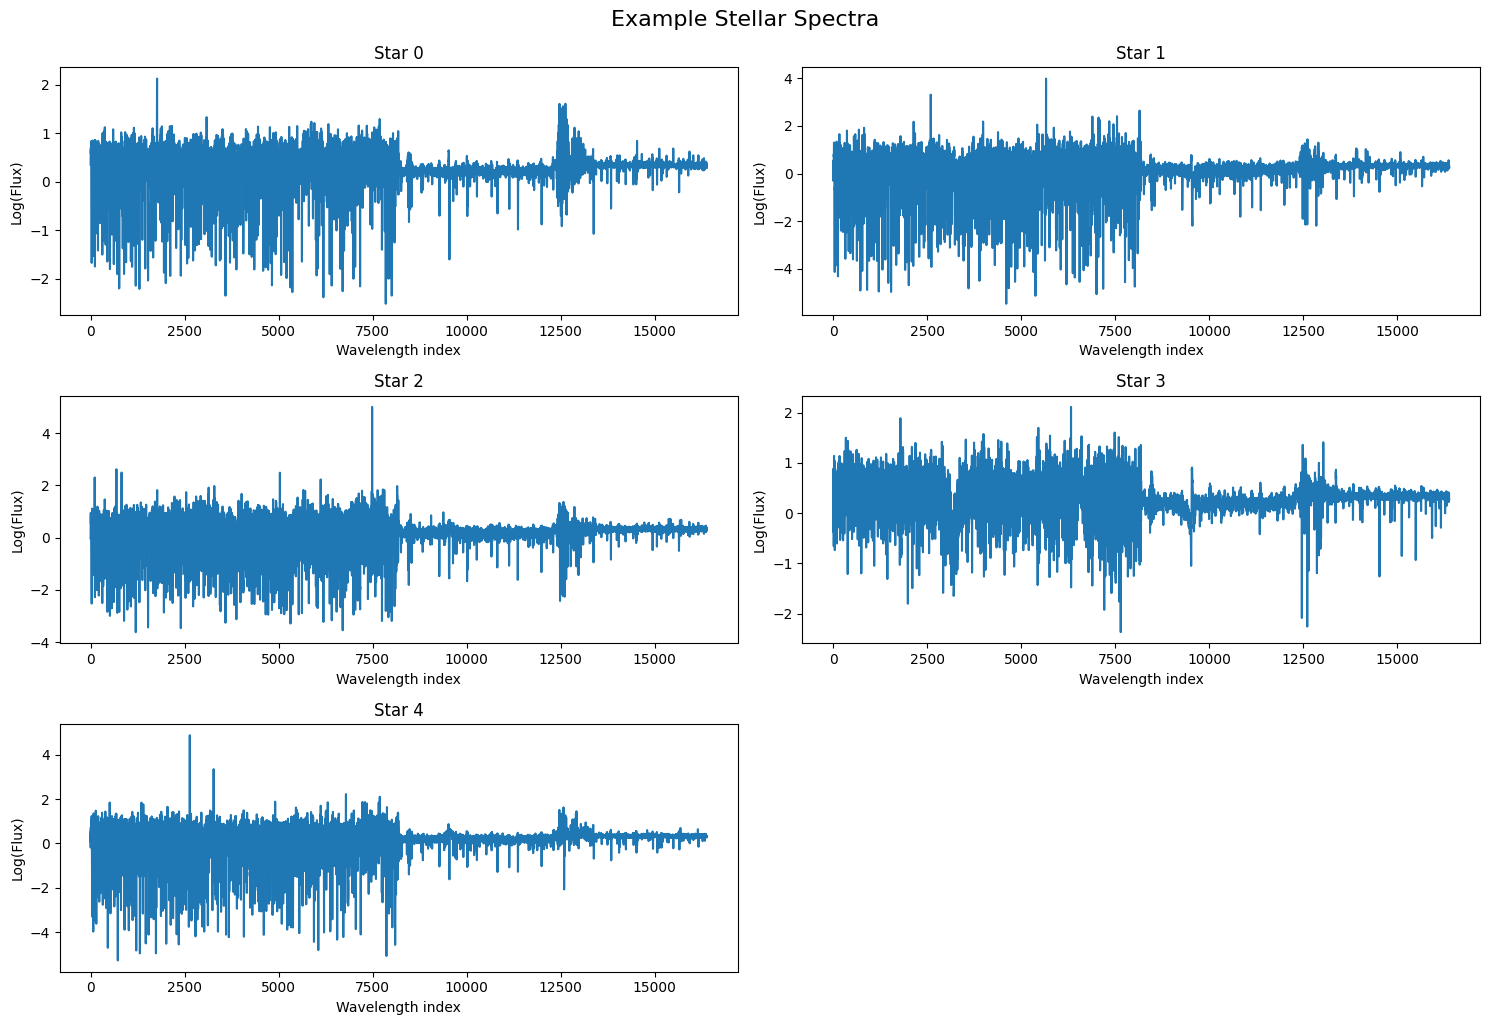

In [29]:
# Plot spectra
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(3, 2, i+1)
    plt.plot(spectra[i])
    plt.title(f"Star {i}")
    plt.xlabel("Wavelength index")
    plt.ylabel("Log(Flux)")
    plt.tight_layout()

plt.suptitle("Example Stellar Spectra", fontsize=16, y=1.02)
plt.show()

In [30]:
spectra_tensor = torch.tensor(spectra, dtype=torch.float32).unsqueeze(1)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

dataset = TensorDataset(spectra_tensor, labels_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

sample_input, sample_target = next(iter(train_loader))
print(sample_target.shape)
print(sample_target[0])

torch.Size([32, 3])
tensor([-1.0868, -1.4535, -0.6430])


In [31]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the CNN model with dynamic computation of the flattened dimension
class AstronomyCNN(nn.Module):
    def __init__(self, input_length):
        super(AstronomyCNN, self).__init__()
        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(16)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(32)
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Compute flattened dimension dynamically
        dummy = torch.zeros(1, 1, input_length)
        out = self.pool(F.relu(self.bn1(self.conv1(dummy))))
        out = self.pool(F.relu(self.bn2(self.conv2(out))))
        flat_dim = out.view(1, -1).shape[1]

        # Fully connected layers with dropout for regularization
        self.fc1 = nn.Linear(flat_dim, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        # Split output into 3 means and 3 log-variances
        mu = x[:, :3]
        log_var = x[:, 3:]
        # Clamp log_var for numerical stability
        log_var = torch.clamp(log_var, min=-10, max=10)
        return mu, log_var


# Define the Gaussian negative log-likelihood loss function
def gaussian_nll_loss(mu, log_var, target):
    var = torch.exp(log_var) + 1e-6  # add epsilon for stability
    nll = 0.5 * math.log(2 * math.pi) + 0.5 * log_var + ((target - mu) ** 2) / (2 * var)
    return nll.mean()


# --- Data Preparation ---
# Simulate dummy training and validation data
train_inputs = torch.randn(n_train, 1, input_length)  # shape: (n_train, 1, input_length)
train_labels = torch.randn(n_train, 3)                # labels: (temperature, gravity, metallicity)
valid_inputs = torch.randn(n_valid, 1, input_length)
valid_labels = torch.randn(n_valid, 3)

# Apply normalization to inputs and labels
train_inputs = (train_inputs - train_inputs.mean()) / train_inputs.std()
valid_inputs = (valid_inputs - valid_inputs.mean()) / valid_inputs.std()

train_labels = (train_labels - train_labels.mean(dim=0)) / train_labels.std(dim=0)
valid_labels = (valid_labels - valid_labels.mean(dim=0)) / valid_labels.std(dim=0)

# Create PyTorch datasets and loaders
train_dataset = TensorDataset(train_inputs, train_labels)
valid_dataset = TensorDataset(valid_inputs, valid_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


# --- Model, Optimizer, and Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AstronomyCNN(input_length=input_length).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


# --- Training Loop ---
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        mu, log_var = model(inputs)
        loss = gaussian_nll_loss(mu, log_var, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        running_loss += loss.item()
        scheduler.step(avg_val_loss)


    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    # --- Validation Loop ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            mu, log_var = model(inputs)
            loss = gaussian_nll_loss(mu, log_var, targets)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(valid_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

print("Training complete!")


Epoch [1/30], Training Loss: 1.9976
Epoch [1/30], Validation Loss: 1.4240
Epoch [2/30], Training Loss: 1.4263
Epoch [2/30], Validation Loss: 1.4196
Epoch [3/30], Training Loss: 1.4211
Epoch [3/30], Validation Loss: 1.4195
Epoch [4/30], Training Loss: 1.4262
Epoch [4/30], Validation Loss: 1.4195
Epoch [5/30], Training Loss: 1.4220
Epoch [5/30], Validation Loss: 1.4195
Epoch [6/30], Training Loss: 1.4218
Epoch [6/30], Validation Loss: 1.4195
Epoch [7/30], Training Loss: 1.4173
Epoch [7/30], Validation Loss: 1.4194
Epoch [8/30], Training Loss: 1.4224
Epoch [8/30], Validation Loss: 1.4194
Epoch [9/30], Training Loss: 1.4130
Epoch [9/30], Validation Loss: 1.4194
Epoch [10/30], Training Loss: 1.4241
Epoch [10/30], Validation Loss: 1.4194
Epoch [11/30], Training Loss: 1.4211
Epoch [11/30], Validation Loss: 1.4194
Epoch [12/30], Training Loss: 1.4176
Epoch [12/30], Validation Loss: 1.4194
Epoch [13/30], Training Loss: 1.4175
Epoch [13/30], Validation Loss: 1.4194
Epoch [14/30], Training Loss: 

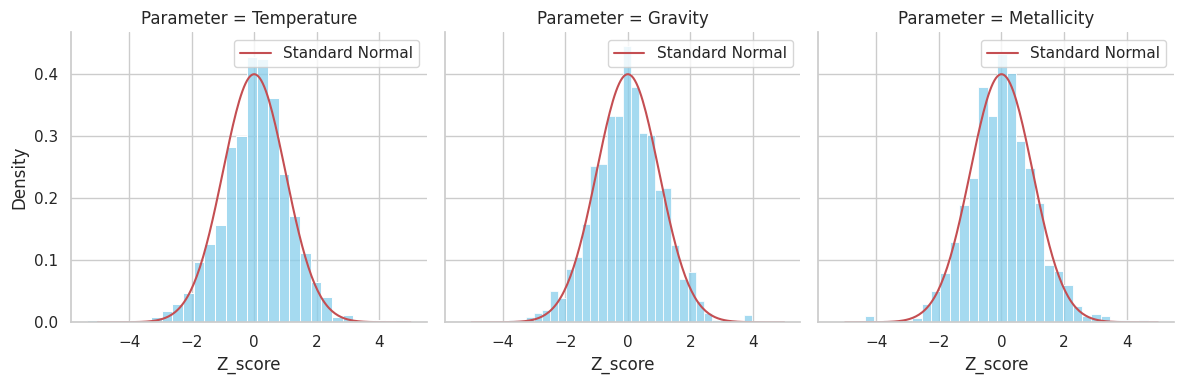

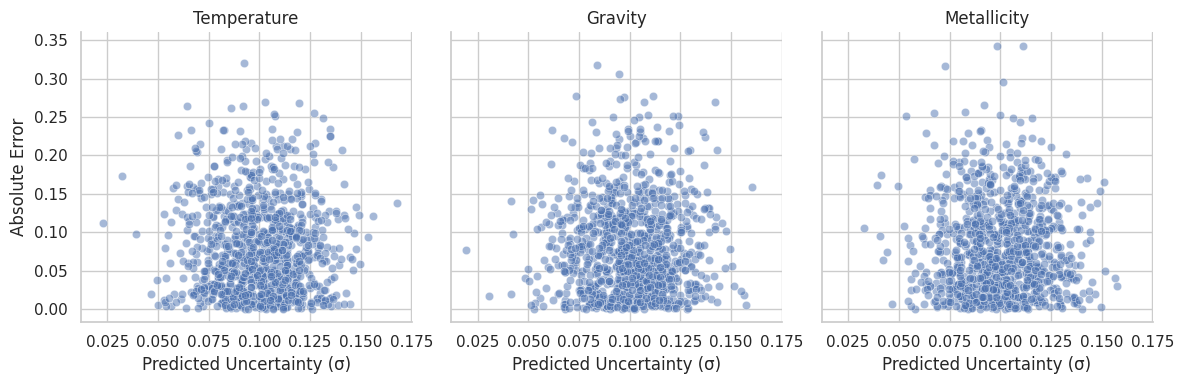

Temperature - Coverage for ±1σ: 67.90%
Gravity - Coverage for ±1σ: 64.90%
Metallicity - Coverage for ±1σ: 66.80%
Temperature - Coverage for ±2σ: 93.40%
Gravity - Coverage for ±2σ: 93.30%
Metallicity - Coverage for ±2σ: 93.60%
Temperature - Coverage for ±3σ: 99.00%
Gravity - Coverage for ±3σ: 99.10%
Metallicity - Coverage for ±3σ: 98.70%


In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------
# ASSUMPTION:
# The following variables are produced by your model:
# y_true, y_pred, sigma_pred
#
# For example, if using a deep learning framework, you might have:
# y_true = test_targets  # shape: (n_samples, 3)
# y_pred, sigma_pred = model.predict(test_inputs)
#
# If these are tensors, convert them to numpy arrays:
# y_true = y_true.numpy() if hasattr(y_true, 'numpy') else y_true
# y_pred = y_pred.numpy() if hasattr(y_pred, 'numpy') else y_pred
# sigma_pred = sigma_pred.numpy() if hasattr(sigma_pred, 'numpy') else sigma_pred
# -------------

# Compute standardized residuals (z-scores)
# z_score = (true value - predicted mean) / predicted uncertainty
z_scores = (y_true - y_pred) / sigma_pred

# Define parameter names
parameters = ['Temperature', 'Gravity', 'Metallicity']

# -----------------------------------
# 1. Visualize Z-Score Distributions using Seaborn FacetGrid
# -----------------------------------

# Prepare a DataFrame for z-scores
df_z = pd.DataFrame(z_scores, columns=parameters)
df_z_melt = df_z.melt(var_name='Parameter', value_name='Z_score')

# Set a seaborn style
sns.set(style="whitegrid")

# Create a FacetGrid to plot one histogram per parameter
g = sns.FacetGrid(df_z_melt, col="Parameter", col_wrap=3, sharex=True, sharey=True, height=4)
g.map(sns.histplot, "Z_score", bins=30, stat="density", color="skyblue", kde=False)

# Generate x-values for the standard normal curve
x_vals = np.linspace(-5, 5, 200)
# Compute the standard normal PDF without using scipy
standard_normal_pdf = np.exp(-0.5 * x_vals**2) / np.sqrt(2 * np.pi)

# Overlay the standard normal curve on each facet
for ax in g.axes.flat:
    ax.plot(x_vals, standard_normal_pdf, 'r-', label="Standard Normal")
    ax.legend()

plt.tight_layout()
plt.show()

# -----------------------------------
# 2. Scatter Plots: Predicted Uncertainty vs. Absolute Error
# -----------------------------------

# Build a DataFrame with absolute error and predicted uncertainty for each parameter
data_list = []
for i, param in enumerate(parameters):
    abs_error = np.abs(y_true[:, i] - y_pred[:, i])
    uncertainty = sigma_pred[:, i]
    for j in range(len(abs_error)):
        data_list.append({
            "Parameter": param,
            "Absolute Error": abs_error[j],
            "Predicted Uncertainty": uncertainty[j]
        })
df_scatter = pd.DataFrame(data_list)

# Create a FacetGrid scatter plot for each parameter
g2 = sns.FacetGrid(df_scatter, col="Parameter", col_wrap=3, height=4)
g2.map_dataframe(sns.scatterplot, x="Predicted Uncertainty", y="Absolute Error", alpha=0.5)
g2.set_axis_labels("Predicted Uncertainty (σ)", "Absolute Error")
g2.set_titles("{col_name}")
plt.tight_layout()
plt.show()

# -----------------------------------
# 3. Coverage Analysis
# -----------------------------------
# For a Gaussian distribution, we expect about:
#   68% of data within ±1σ, 95% within ±2σ, and 99.7% within ±3σ.
# Here we compute the empirical coverage for each parameter.

for k in [1, 2, 3]:
    coverage = np.mean(np.abs(z_scores) < k, axis=0)  # Compute per parameter
    for i, param in enumerate(parameters):
        print(f'{param} - Coverage for ±{k}σ: {coverage[i]*100:.2f}%')
